torch.Size([8, 5749])
Batch 1/3 - Loss: 8.6335
Batch 2/3 - Loss: 8.7398
Batch 3/3 - Loss: 8.8076
Batch 4 loss: 8.7820
Batch 5 loss: 8.7641
Batch 6 loss: 8.6330
Batch 7 loss: 8.5170
Batch 8 loss: 8.5990
Batch 9 loss: 8.6708
Batch 10 loss: 8.5654
Batch 11 loss: 8.8595
Batch 12 loss: 8.5610
Batch 13 loss: 8.6763
Batch 14 loss: 8.6918
Batch 15 loss: 8.3394
Batch 16 loss: 8.4642
Batch 17 loss: 8.6572
Batch 18 loss: 8.7302
Batch 19 loss: 8.6564
Batch 20 loss: 8.1498
Batch 21 loss: 8.2210
Batch 22 loss: 8.1485
Batch 23 loss: 8.2402

Average loss over batches 4–10: 8.5463


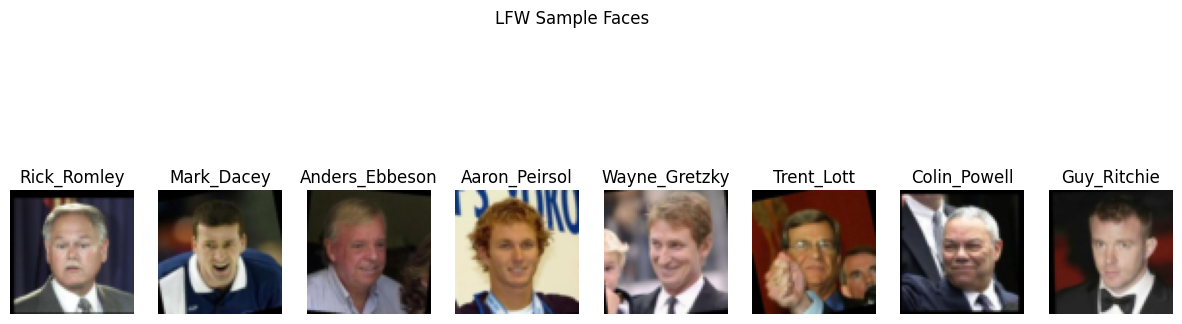

Original prediction: George_W_Bush
Adversarial prediction: George_W_Bush
Clean prediction confidence: 0.027188125997781754
Adversarial prediction confidence: 0.12561237812042236


In [20]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Ensure reproducibility
torch.manual_seed(0)

# Path to manually downloaded LFW dataset
lfw_path = '../lfw-deepfunneled'  # Adjust if needed

# Define transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Use ImageFolder
lfw_dataset = datasets.ImageFolder(root=lfw_path, transform=transform)
lfw_loader = DataLoader(lfw_dataset, batch_size=8, shuffle=True)

# Display function
def show_images(images, titles=None, title=''):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img.permute(1, 2, 0))
        if titles:
            ax.set_title(titles[i])
        ax.axis('off')
    plt.suptitle(title)
    plt.show()


# Get a batch and show
# images, labels = next(iter(lfw_loader))
# show_images(images, labels, lfw_dataset.classes, title='LFW Sample Faces')

## Load and Test Simple CNN
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 3, 64, 64] -> [B, 32, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 32, 32, 32]

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B, 64, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 64, 16, 16]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                                # [B, 64*16*16]
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)                  # Output logits
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
num_classes = len(lfw_dataset.classes)
model = SimpleCNN(num_classes)

# Get a batch
images, labels = next(iter(lfw_loader))

# Pass through model
outputs = model(images)

# Show prediction scores for each image
print(outputs.shape)  # should be [8, num_classes]

## Training

import torch.optim as optim

# Define loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Switch model to training mode
model.train()

# Train for 3 batches only
for batch_idx, (images, labels) in enumerate(lfw_loader):
    if batch_idx >= 3:
        break

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images)

    # Compute loss
    loss = criterion(outputs, labels)

    # Backward pass + optimise
    loss.backward()
    optimizer.step()

    print(f"Batch {batch_idx+1}/3 - Loss: {loss.item():.4f}")
    
    # Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Continue training for 7 more batches
model.train()  # Set model to training mode
running_loss = 0.0

# Skip the first 3 batches already done
train_iter = iter(lfw_loader)
for _ in range(3):
    next(train_iter)

# Train next 7 batches
for batch_idx in range(20):
    images, labels = next(train_iter)
    
    # Zero gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass and optimise
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    print(f'Batch {batch_idx + 4} loss: {loss.item():.4f}')  # +4 since we're continuing from batch 4

print(f"\nAverage loss over batches 4–10: {running_loss / 20:.4f}")

## FGSM attack

def fgsm_attack(image, epsilon, data_grad):
    # Sign of the gradient
    sign_data_grad = data_grad.sign()
    # Perturb the image
    perturbed_image = image + epsilon * sign_data_grad
    # Clamp the image to [0,1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Get one image and label
image, label = next(iter(lfw_loader))
image = image[0].unsqueeze(0)  # Shape: [1, C, H, W]
label = label[0].unsqueeze(0)  # Shape: [1]

# Set requires_grad
image.requires_grad = True

# Forward pass
output = model(image)
loss = criterion(output, label)

# Backward pass
model.zero_grad()
loss.backward()

# Generate adversarial image
epsilon = 0.15  # Try increasing from 0.05
data_grad = image.grad.data
perturbed_image = fgsm_attack(image, epsilon, data_grad)

# Visualise original vs adversarial

titles = [lfw_dataset.classes[label] for label in labels]
show_images(images, titles=titles, title='LFW Sample Faces')

# Turn off gradient tracking to test the effect of fgsm
model.eval()
with torch.no_grad():
    output_clean = model(image)
    output_adv = model(perturbed_image)

clean_pred = output_clean.argmax(dim=1).item()
adv_pred = output_adv.argmax(dim=1).item()

print(f"Original prediction: {lfw_dataset.classes[clean_pred]}")
print(f"Adversarial prediction: {lfw_dataset.classes[adv_pred]}")
print("Clean prediction confidence:", torch.softmax(output_clean, dim=1).max().item())
print("Adversarial prediction confidence:", torch.softmax(output_adv, dim=1).max().item())



